In [1]:
import keras
from keras import models
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, LeakyReLU, Activation, Dropout, MaxPooling2D,UpSampling2D
from keras.layers import Layer, Reshape, Conv2DTranspose, Lambda, ReLU, BatchNormalization
from keras.metrics import binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint 
from keras.utils import plot_model
from keras.datasets import mnist, cifar10
from tqdm import tqdm
from io import BytesIO, StringIO
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import numpy as np
import cv2
import os, random, re, imageio, time, inspect
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf
# Esto es solo necesario en el caso de tener varías GPUs en el equipo
#os.environ["CUDA_VISIBLE_DEVICES"]="0" 
#sess = tf.Session()
#Para asegurar que usamos GPU listamos las unidades que pueden procesar
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#print("-------------------------------------")
#import tensorflow as tf
#def get_available_devices():
#    local_device_protos = device_lib.list_local_devices()
#    return [x.name for x in local_device_protos]
#get_available_devices()

In [3]:
def crea_cuadrados(lado):
    input_data = np.ones((lado,lado,lado,1),dtype=np.uint8)
    for i in range(lado):
        input_data[i,:i,:i,0] = 0
    return input_data

def crea_circulos(radio):
   d = 2*radio + 1
   rx, ry = d/2, d/2
   x, y = np.indices((d, d))
   l = (-(np.hypot(rx - x, ry - y)-radio < 0.5).astype(int)).tolist()
   m=[]
   c=[]
   for i in l:
     for a in i:
      if a == -1:
        c.append([0]) 
      else :
        c.append([1])
     m.append(c)
     c=[]
   return m

def crea_triangulos(lado):
  l = np.tri(lado,k=0,dtype=np.uint8).tolist()
  m=[]
  c=[]
  for i in l:
    for a in i:
      if a == 1:
        c.append([0]) 
      else :
        c.append([1]) 
    m.append(c)
    c=[]
  return m

In [4]:
def crea_dataset_circulos2(dimensiones):
  if dimensiones%2 == 0:
    radio = int(dimensiones/2-1)
  else:
    radio = int((dimensiones-1)/2 )
  n = []
  for i in range(radio):
    num_circ = i
    b = crea_circulos(num_circ) 
    a = np.ones((dimensiones-(num_circ*2+1),1),dtype=np.uint8) 
    a.tolist() 
    for z in range(len(b)):
      for i in a:
        b[z].append(i.tolist())
    for y in range(dimensiones-(num_circ*2+1)):
      b.append(np.ones((dimensiones,1),dtype=np.uint8).tolist())
    n.append(b)   
  return np.array(n)

def crea_dataset_triangulos2(numero_de_triangulos):
  dim = numero_de_triangulos
  n = []
  for i in range(dim):
    num_tria = i
    b = crea_triangulos(num_tria) 
    a = np.ones((dim-num_tria,1),dtype=np.uint8) 
    a.tolist() 
    for z in range(len(b)):
      for i in a:
        b[z].append(i.tolist())
    for y in range(dim-num_tria):
      b.append(np.ones((dim,1),dtype=np.uint8).tolist())
    n.append(b)   
  return np.array(n)

Experimento 1: Cuadrados

En este experimento creamos un dataset de 100 imágenes de cuadrados de distinto tamaño para realizar una codificación del espacio latente de una sola dimensión. Queremos probar que el autoencoder es capaz de llegar a comprender que con solo una dimensión, que en este caso es el lado del cuadrado, es capaz de recrear el resto de la figura.

In [5]:
#Limpiamos la sesion
tf.keras.backend.clear_session()


#Creamos el dataset
input_data = crea_cuadrados(100)

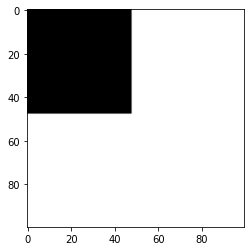

In [6]:
#Podemos ver una muestra del conjunto de elementos
img_visual = input_data[48]
plt.imshow(img_visual.reshape(img_visual.shape[:2]),cmap='gray')

In [7]:
#Creamos el autoencoder para la realización de las 3 pruebas 
# Fijamos el valor de la dimensión del espacio latente
dim_espacio_latente = 1
mi_lado = 100
# Definimos el encoder 

# Fijamos el valor de la dimensión del espacio latente
dim_espacio_latente = 1

#Nota Sergio: Con Input instanciamos un tensor de keras : https://keras.io/api/layers/core_layers/input/
input_img = Input(shape=(mi_lado, mi_lado, 1))


#Nota Sergio: Como hemos importado el nombre de las funciones anteriormente 
#             con un as distinto no es necesario poner layers.nombre_de_la_capa

#Nota Sergio: Aplicamos una capa de convolucion a la imagen para empezar a reducir la dimension
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


# Guardo el tamaño antes de aplanar, para recuperarlo
# en el decodificador
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x) 
encoder_output= Dense(dim_espacio_latente,name='encoder_output')(x) 

encoder_1 = Model(input_img, encoder_output)

# Definimos el decoder
decoder_input= Input((dim_espacio_latente,))
x = Dense(np.prod(shape_before_flattening),activation='relu')(decoder_input) #(2)
x = Reshape(shape_before_flattening)(x) 
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder_1 = Model(decoder_input, decoded)


# Definimos la entrada del autoencoder
autoencoder_1_input = Input(shape=(mi_lado, mi_lado, 1))
# Definimos la salida del encoder
encoded_1 = encoder_1(autoencoder_1_input)
# Definimos la salida del decoder
decoded_1 = decoder_1(encoded_1)
# Creamos el autoencoder enlazando la entrada con la salida que queremos
autoencoder_1 = Model(autoencoder_1_input, decoded_1)


autoencoder_1.compile(optimizer=Adam(), loss = 'mean_squared_error')

In [8]:
#Ahora entrenamos la red con los cuadrados
history_1 = autoencoder_1.fit(x=input_data, 
                              y=input_data, 
                              batch_size=20, 
                              shuffle=True, 
                              epochs=500)

Epoch 1/500
5/5 [==============================] - 1s 148ms/step - loss: 0.2496
Epoch 2/500
5/5 [==============================] - 1s 148ms/step - loss: 0.2489
Epoch 3/500
5/5 [==============================] - 1s 146ms/step - loss: 0.2475
Epoch 4/500
5/5 [==============================] - 1s 151ms/step - loss: 0.2452
Epoch 5/500
5/5 [==============================] - 1s 148ms/step - loss: 0.2407
Epoch 6/500
5/5 [==============================] - 1s 145ms/step - loss: 0.2337
Epoch 7/500
5/5 [==============================] - 1s 147ms/step - loss: 0.2217
Epoch 8/500
5/5 [==============================] - 1s 146ms/step - loss: 0.2065
Epoch 9/500
5/5 [==============================] - 1s 143ms/step - loss: 0.1963
Epoch 10/500
5/5 [==============================] - 1s 145ms/step - loss: 0.1888
Epoch 11/500
5/5 [==============================] - 1s 147ms/step - loss: 0.1838
Epoch 12/500
5/5 [==============================] - 1s 147ms/step - loss: 0.1784
Epoch 13/500
5/5 [===================

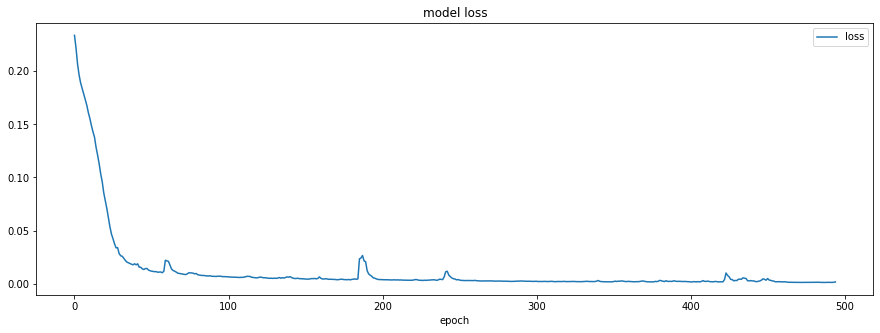

In [9]:
#Resultados del entrenamiento
start_plot = 5

mpl.rcParams['figure.figsize'] = (15,5)
plt.plot(history_1.history['loss'][start_plot:], label = 'loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc ='upper right')
plt.show()

In [10]:
def draw2compare(*args):
    n = len(args[0])
    plt.figure(figsize=(20, 2*len(args)))
    for i in range(n):
        for j in range(len(args)):
            img = args[j][i]
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            if len(img.shape) == 3 and img.shape[2] == 1:
                plt.imshow(img.reshape(img.shape[:2]))
            else:
                plt.imshow(img)

            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [11]:
# Con mini y maxi fijamos el intervalo de índices de las imagenes que queremos comparar
mini = 20
maxi = 31

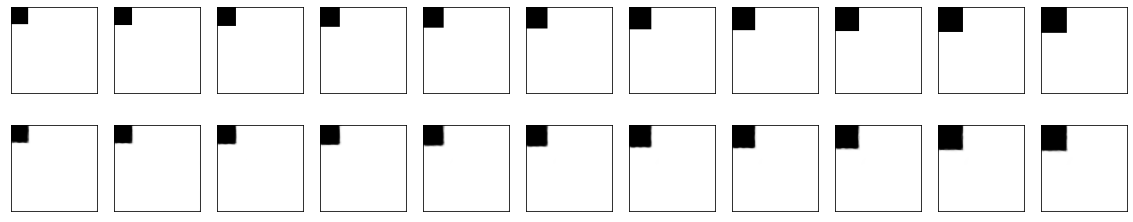

In [12]:
# Calculamos la salida del autoencoder para las imágenes de ese intervalo
decoded_imgs = autoencoder_1.predict(input_data[mini:maxi])

# Dibujamos las imágenes
draw2compare(input_data[mini:maxi], decoded_imgs)

In [13]:
#Vemaos cuales son los valores de las codificaciones de las figuras
latente_1 = encoder_1.predict(input_data)

# Vemos los 5 primeros valores
latente_1[:5]

array([[0.3973277 ],
       [0.3954065 ],
       [0.3631625 ],
       [0.35685563],
       [0.34747103]], dtype=float32)

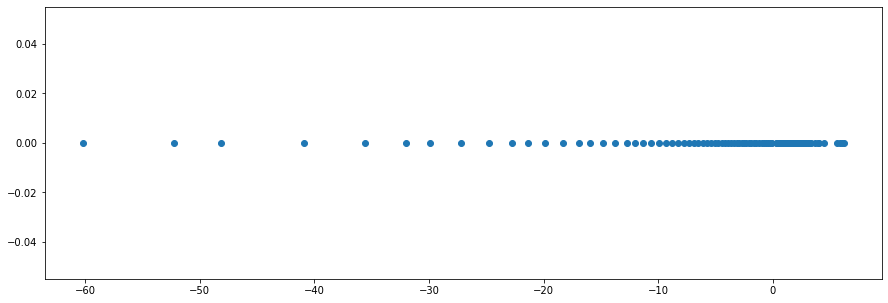

In [14]:
#Veamos como es la ditribucion en el espacio de las figuras
mpl.rcParams['figure.figsize'] = (15,5)
plt.scatter(latente_1,[0]*len(latente_1))
plt.show()

(0.0, 40.0)

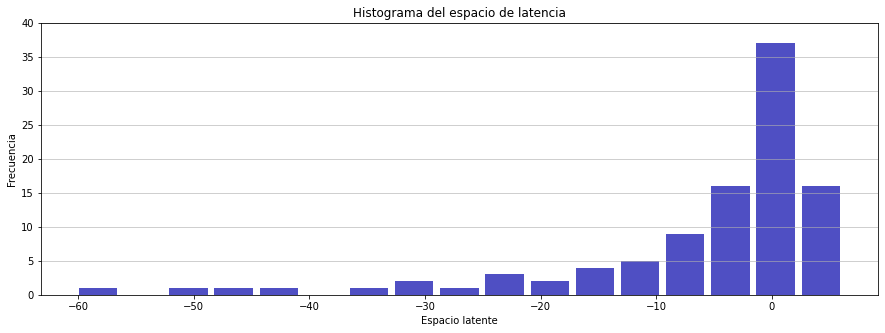

In [15]:
#El histograma
n, bins, patches = plt.hist(x=latente_1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Espacio latente')
plt.ylabel('Frecuencia')
plt.title('Histograma del espacio de latencia')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

[-0.59129983]


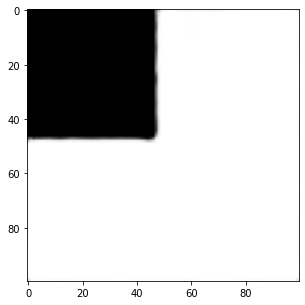

In [16]:
#Ejemplo de una codificación/decodificación
num_decod = 48
print(latente_1[num_decod])
imagen_sal_1 = decoder_1.predict(latente_1[num_decod])

plt.imshow(imagen_sal_1.reshape(imagen_sal_1.shape[1:3]),cmap='gray')

[0.39806563]


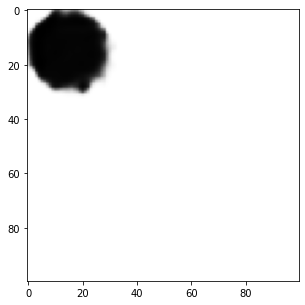

In [44]:
#Generamos un valor nuevo
# Tomamos un valor aleatorio entre 0 y 1
nuevo_1 = np.random.rand(1).astype('float32')
print(nuevo_1)
# Vemos el resultado de su decodificación
imagen_sal_2 = decoder_1.predict(nuevo_1)
plt.imshow(imagen_sal_2.reshape(imagen_sal_2.shape[1:3]),cmap='gray')

In [18]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

Experimento 2: Triangulos


In [19]:
#Limpiamos la sesion
tf.keras.backend.clear_session()

input_data = crea_dataset_triangulos2(100)

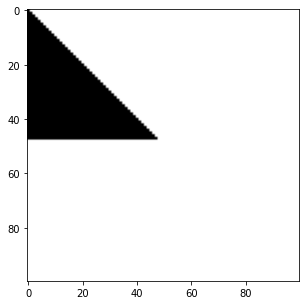

In [20]:
#Podemos ver una muestra del conjunto de elementos
img_visual = input_data[48]
plt.imshow(img_visual.reshape(img_visual.shape[:2]),cmap='gray')

In [21]:
#Creamos el autoencoder para la realización de las 3 pruebas 
# Fijamos el valor de la dimensión del espacio latente
dim_espacio_latente = 1
mi_lado = 100
# Definimos el encoder 

# Fijamos el valor de la dimensión del espacio latente
dim_espacio_latente = 1

#Nota Sergio: Con Input instanciamos un tensor de keras : https://keras.io/api/layers/core_layers/input/
input_img = Input(shape=(mi_lado, mi_lado, 1))


#Nota Sergio: Como hemos importado el nombre de las funciones anteriormente 
#             con un as distinto no es necesario poner layers.nombre_de_la_capa

#Nota Sergio: Aplicamos una capa de convolucion a la imagen para empezar a reducir la dimension
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


# Guardo el tamaño antes de aplanar, para recuperarlo
# en el decodificador
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x) 
encoder_output= Dense(dim_espacio_latente,name='encoder_output')(x) 

encoder_1 = Model(input_img, encoder_output)

# Definimos el decoder
decoder_input= Input((dim_espacio_latente,))
x = Dense(np.prod(shape_before_flattening),activation='relu')(decoder_input) #(2)
x = Reshape(shape_before_flattening)(x) 
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder_1 = Model(decoder_input, decoded)


# Definimos la entrada del autoencoder
autoencoder_1_input = Input(shape=(mi_lado, mi_lado, 1))
# Definimos la salida del encoder
encoded_1 = encoder_1(autoencoder_1_input)
# Definimos la salida del decoder
decoded_1 = decoder_1(encoded_1)
# Creamos el autoencoder enlazando la entrada con la salida que queremos
autoencoder_1 = Model(autoencoder_1_input, decoded_1)


autoencoder_1.compile(optimizer=Adam(), loss = 'mean_squared_error')

In [22]:
#Ahora entrenamos la red con los cuadrados
history_1 = autoencoder_1.fit(x=input_data, 
                              y=input_data, 
                              batch_size=20, 
                              shuffle=True, 
                              epochs=500)

Epoch 1/500
5/5 [==============================] - 1s 151ms/step - loss: 0.2491
Epoch 2/500
5/5 [==============================] - 1s 153ms/step - loss: 0.2462
Epoch 3/500
5/5 [==============================] - 1s 148ms/step - loss: 0.2408
Epoch 4/500
5/5 [==============================] - 1s 152ms/step - loss: 0.2278
Epoch 5/500
5/5 [==============================] - 1s 151ms/step - loss: 0.1994
Epoch 6/500
5/5 [==============================] - 1s 151ms/step - loss: 0.1518
Epoch 7/500
5/5 [==============================] - 1s 151ms/step - loss: 0.1229
Epoch 8/500
5/5 [==============================] - 1s 152ms/step - loss: 0.1207
Epoch 9/500
5/5 [==============================] - 1s 151ms/step - loss: 0.1127
Epoch 10/500
5/5 [==============================] - 1s 151ms/step - loss: 0.1035
Epoch 11/500
5/5 [==============================] - 1s 153ms/step - loss: 0.0981
Epoch 12/500
5/5 [==============================] - 1s 151ms/step - loss: 0.0961
Epoch 13/500
5/5 [===================

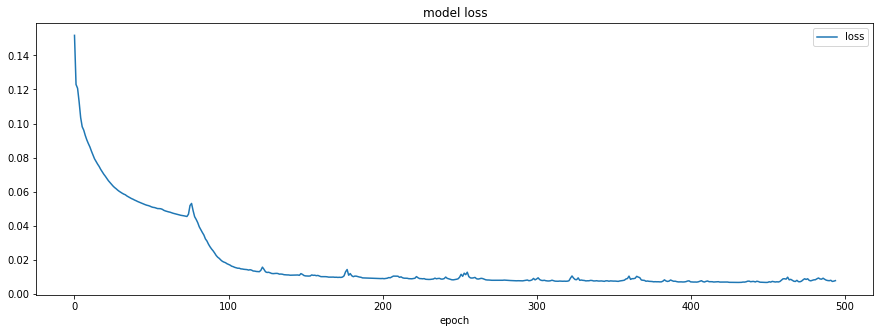

In [23]:
#Resultados del entrenamiento
start_plot = 5

mpl.rcParams['figure.figsize'] = (15,5)
plt.plot(history_1.history['loss'][start_plot:], label = 'loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc ='upper right')
plt.show()

In [24]:
# Con mini y maxi fijamos el intervalo de índices de las imagenes que queremos comparar
mini = 20
maxi = 31

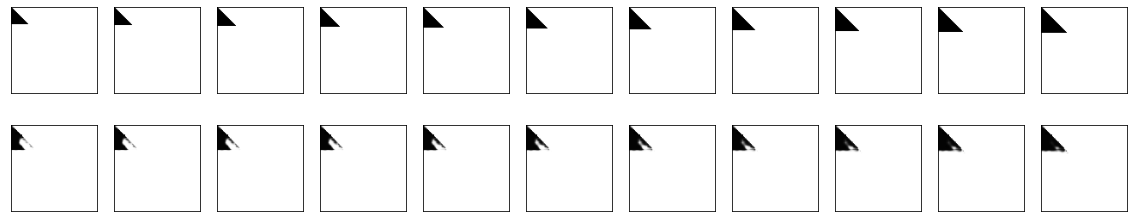

In [25]:
# Calculamos la salida del autoencoder para las imágenes de ese intervalo
decoded_imgs = autoencoder_1.predict(input_data[mini:maxi])

# Dibujamos las imágenes
draw2compare(input_data[mini:maxi], decoded_imgs)

In [26]:
latente_1 = encoder_1.predict(input_data)

# Vemos los 5 primeros valores
latente_1[:5]

array([[167.04874],
       [167.04662],
       [167.05087],
       [167.06345],
       [167.02267]], dtype=float32)

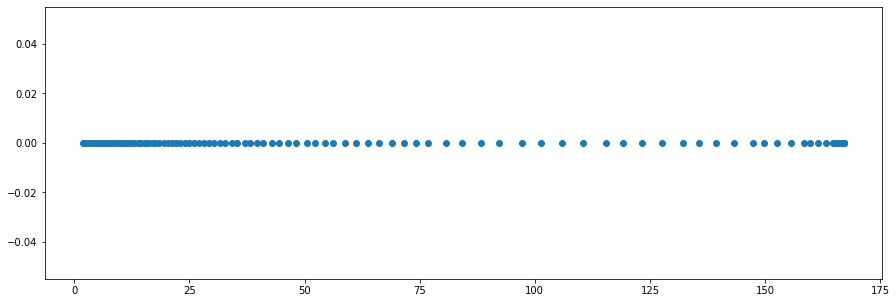

In [27]:
mpl.rcParams['figure.figsize'] = (15,5)
plt.scatter(latente_1,[0]*len(latente_1))
plt.show()

(0.0, 40.0)

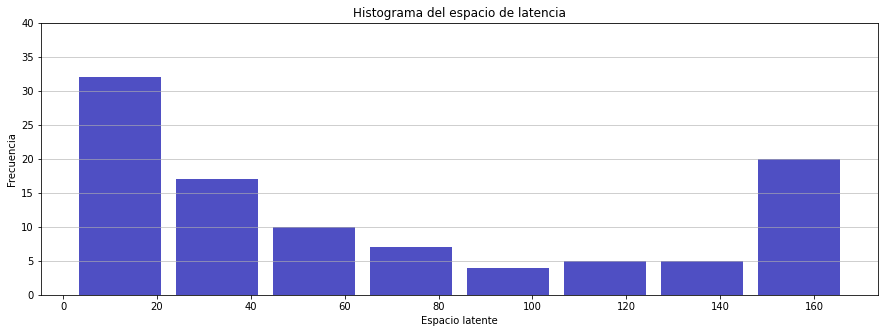

In [28]:
n, bins, patches = plt.hist(x=latente_1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Espacio latente')
plt.ylabel('Frecuencia')
plt.title('Histograma del espacio de latencia')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

[48.167507]


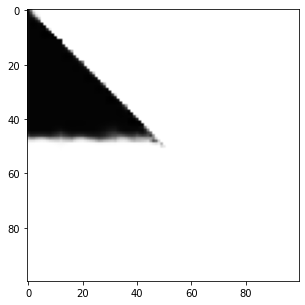

In [29]:
num_decod = 48
print(latente_1[num_decod])
imagen_sal_1 = decoder_1.predict(latente_1[num_decod])

plt.imshow(imagen_sal_1.reshape(imagen_sal_1.shape[1:3]),cmap='gray')

[0.49151528]


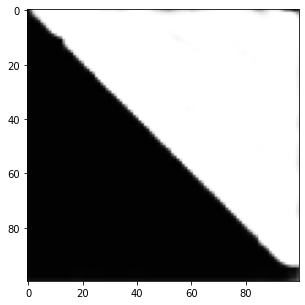

In [30]:
# Tomamos un valor aleatorio entre 0 y 1
nuevo_1 = np.random.rand(1).astype('float32')
print(nuevo_1)
# Vemos el resultado de su decodificación
imagen_sal_2 = decoder_1.predict(nuevo_1)
plt.imshow(imagen_sal_2.reshape(imagen_sal_2.shape[1:3]),cmap='gray')

In [31]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

Experimento 3: Círculos

Para este exparimento probamos con una figura mas compleja, el objetivo es ver si el autoencoder puede  comprimir la información a la variable del radio del círculo.


In [32]:
#Limpiamos la sesion
tf.keras.backend.clear_session()
input_data = crea_dataset_circulos2(100)

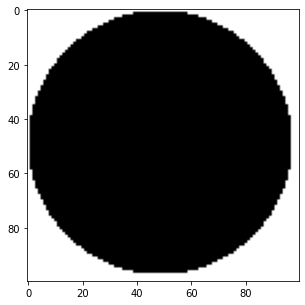

In [33]:
img_visual = input_data[48]
plt.imshow(img_visual.reshape(img_visual.shape[:2]),cmap='gray')

In [34]:
#Creamos el autoencoder para la realización de las 3 pruebas 
# Fijamos el valor de la dimensión del espacio latente
dim_espacio_latente = 1
mi_lado = 100
# Definimos el encoder 

# Fijamos el valor de la dimensión del espacio latente
dim_espacio_latente = 1

#Nota Sergio: Con Input instanciamos un tensor de keras : https://keras.io/api/layers/core_layers/input/
input_img = Input(shape=(mi_lado, mi_lado, 1))


#Nota Sergio: Como hemos importado el nombre de las funciones anteriormente 
#             con un as distinto no es necesario poner layers.nombre_de_la_capa

#Nota Sergio: Aplicamos una capa de convolucion a la imagen para empezar a reducir la dimension
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


# Guardo el tamaño antes de aplanar, para recuperarlo
# en el decodificador
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x) 
encoder_output= Dense(dim_espacio_latente,name='encoder_output')(x) 

encoder_1 = Model(input_img, encoder_output)

# Definimos el decoder
decoder_input= Input((dim_espacio_latente,))
x = Dense(np.prod(shape_before_flattening),activation='relu')(decoder_input) #(2)
x = Reshape(shape_before_flattening)(x) 
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder_1 = Model(decoder_input, decoded)


# Definimos la entrada del autoencoder
autoencoder_1_input = Input(shape=(mi_lado, mi_lado, 1))
# Definimos la salida del encoder
encoded_1 = encoder_1(autoencoder_1_input)
# Definimos la salida del decoder
decoded_1 = decoder_1(encoded_1)
# Creamos el autoencoder enlazando la entrada con la salida que queremos
autoencoder_1 = Model(autoencoder_1_input, decoded_1)


autoencoder_1.compile(optimizer=Adam(), loss = 'mean_squared_error')

In [35]:
 #Ahora entrenamos la red con los cuadrados
history_1 = autoencoder_1.fit(x=input_data, 
                              y=input_data, 
                              batch_size=20, 
                              shuffle=True, 
                              epochs=500)

Epoch 1/500
3/3 [==============================] - 0s 96ms/step - loss: 0.2496
Epoch 2/500
3/3 [==============================] - 0s 98ms/step - loss: 0.2477
Epoch 3/500
3/3 [==============================] - 0s 95ms/step - loss: 0.2449
Epoch 4/500
3/3 [==============================] - 0s 96ms/step - loss: 0.2408
Epoch 5/500
3/3 [==============================] - 0s 96ms/step - loss: 0.2326
Epoch 6/500
3/3 [==============================] - 0s 97ms/step - loss: 0.2190
Epoch 7/500
3/3 [==============================] - 0s 96ms/step - loss: 0.2011
Epoch 8/500
3/3 [==============================] - 0s 96ms/step - loss: 0.1778
Epoch 9/500
3/3 [==============================] - 0s 97ms/step - loss: 0.1630
Epoch 10/500
3/3 [==============================] - 0s 94ms/step - loss: 0.1597
Epoch 11/500
3/3 [==============================] - 0s 97ms/step - loss: 0.1585
Epoch 12/500
3/3 [==============================] - 0s 99ms/step - loss: 0.1528
Epoch 13/500
3/3 [==============================]

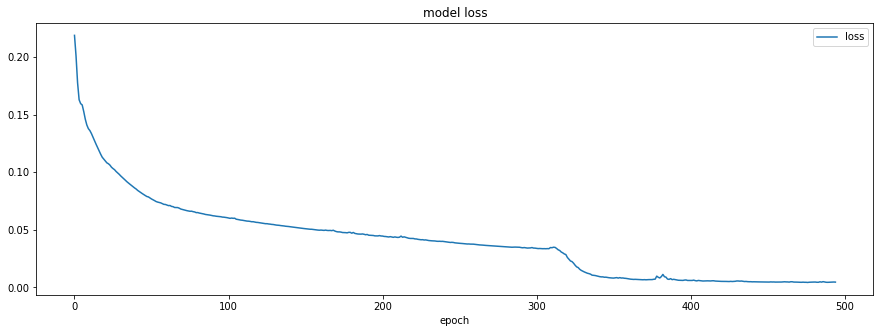

In [36]:
 #Resultados del entrenamiento
start_plot = 5

mpl.rcParams['figure.figsize'] = (15,5)
plt.plot(history_1.history['loss'][start_plot:], label = 'loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc ='upper right')
plt.show()

In [37]:
 # Con mini y maxi fijamos el intervalo de índices de las imagenes que queremos comparar
mini = 20
maxi = 31

In [38]:
latente_1 = encoder_1.predict(input_data)

# Vemos los 5 primeros valores
latente_1[:5]

array([[-53.36063 ],
       [-53.367233],
       [-53.395134],
       [-53.432247],
       [-53.44997 ]], dtype=float32)

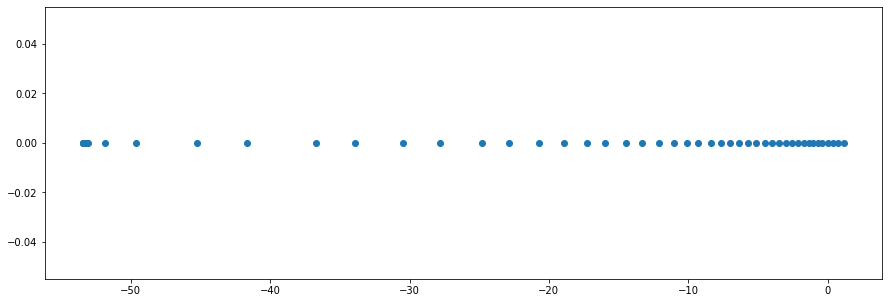

In [39]:
mpl.rcParams['figure.figsize'] = (15,5)
plt.scatter(latente_1,[0]*len(latente_1))
plt.show()

(0.0, 20.0)

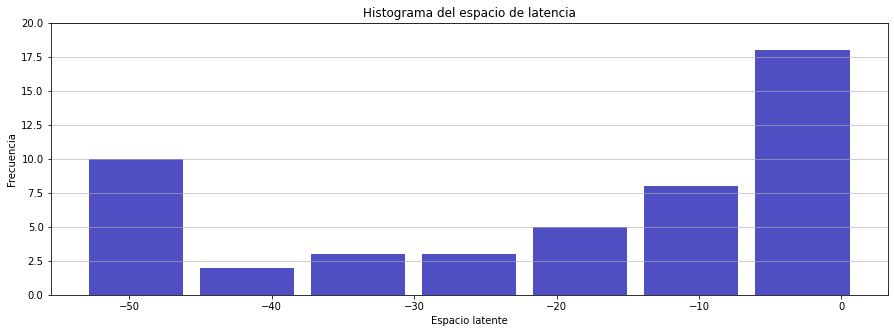

In [40]:
n, bins, patches = plt.hist(x=latente_1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Espacio latente')
plt.ylabel('Frecuencia')
plt.title('Histograma del espacio de latencia')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

[1.1556987]


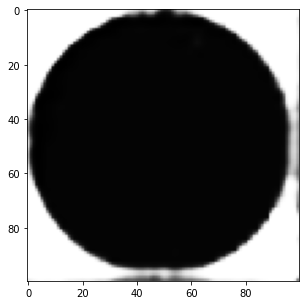

In [41]:
num_decod = 48
print(latente_1[num_decod])
imagen_sal_1 = decoder_1.predict(latente_1[num_decod])

plt.imshow(imagen_sal_1.reshape(imagen_sal_1.shape[1:3]),cmap='gray')

[0.7223261]


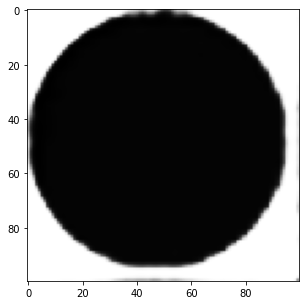

In [42]:
# Tomamos un valor aleatorio entre 0 y 1
nuevo_1 = np.random.rand(1).astype('float32')
print(nuevo_1)
# Vemos el resultado de su decodificación
imagen_sal_2 = decoder_1.predict(nuevo_1)
plt.imshow(imagen_sal_2.reshape(imagen_sal_2.shape[1:3]),cmap='gray')